### Imports

In [45]:
# Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt

# Display all columns
pd.set_option('display.max_columns', None)
# Display all rows
pd.set_option('display.max_rows', None)

A right-handed pitcher is curious about how velocity, movement, and spin rates on fastballs affect the chances of batters putting the ball in play. Attached are two CSV files. Both files contain 10,000 random pitches of fastballs thrown in the strike zone by right-handed pitchers to right-handed batters (swings and takes are both included). One of them (training.csv) also includes whether the batter was able to put the ball in play.


The columns are:

- InPlay – A binary column indicating if the batter put the ball in play (1 = in play, 0 = not in play)
- Velo – The velocity of the pitch at release (in mph)
- SpinRate – The Spin Rate of the pitch at release (in rpm)
- HorzBreak – The amount of movement the pitch had in the horizontal direction (in inches)
- InducedVertBreak – The amount of movement (in inches) the pitch had in the vertical direction after accounting for the effects of gravity. A positive value means the pitch would move up in a gravity-free environment that still had the same air resistance.

##### Question 1

Predict the chance of a pitch being put in play. Please use this model to predict the chance of each pitch in the “deploy.csv” file being put in play and return a CSV with your predictions.

##### Data

In [17]:
# Load the data
df_train = pd.read_csv('training.csv')

##### missing

In [18]:
# Check if there are any missing values in the entire dataset
if df_train.isnull().any().any():
    print("\nThere are missing values in the dataset.")
else:
    print("\nThere are no missing values in the dataset.")


There are missing values in the dataset.


In [20]:
# Check for missing values in each column
missing_values = df_train.isnull().sum()

print("Number of missing values in each column:")
print(missing_values)

Number of missing values in each column:
InPlay              0
Velo                0
SpinRate            6
HorzBreak           0
InducedVertBreak    0
dtype: int64


In [21]:
# Print the number of rows
print(f"There are {len(df_train)} rows in the training.csv file.")

There are 10000 rows in the training.csv file.


In [24]:
# Calculate and print the variance of the SpinRate column
spin_rate_variance = df_train['SpinRate'].std()
print(f"The std of the SpinRate column is: {spin_rate_variance:.2f}")

The std of the SpinRate column is: 196.04


Since there are only 6 missing values and 10,000 rows of data, I am going to opt to not use imputation and delete these 6 rows from our training data. Even though boosting algos typically handle this on their own, I am going to do it for completeness of my modeling process.

In [25]:
# Store the initial number of rows
initial_row_count = len(df_train)

# Remove rows with missing values
df_train_clean = df_train.dropna()

# Calculate how many rows have been removed
rows_removed = initial_row_count - len(df_train_clean)

print(f"{rows_removed} rows have been removed due to missing values.")

6 rows have been removed due to missing values.


##### Preprocess

In [26]:
# Separate predictors and target variable
X = df_train_clean.drop(columns=['InPlay'])
y = df_train_clean['InPlay']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizing the data
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_normalized, y_train)

# Check the distribution of the target variable after SMOTE
print("Distribution of y_train before SMOTE:", y_train.value_counts())
print("Distribution of y_train after SMOTE:", y_train_resampled.value_counts())


Distribution of y_train before SMOTE: 0    5811
1    2184
Name: InPlay, dtype: int64
Distribution of y_train after SMOTE: 0    5811
1    5811
Name: InPlay, dtype: int64


##### Train and Evaluate - ROC AUC

In [29]:
# Training & Evaluating models
models = {
    'Logistic Regression': (LogisticRegression(max_iter=1000), X_train_resampled, X_test_normalized),
    'Random Forest': (RandomForestClassifier(), X_train_resampled, X_test_normalized),
    'SVM': (SVC(probability=True), X_train_resampled, X_test_normalized),
    'Gradient Boosted Trees (XGBoost)': (xgb.XGBClassifier(), X_train_resampled, X_test_normalized),
    'Gradient Boosted Trees (LightGBM)': (lgb.LGBMClassifier(), X_train_resampled, X_test_normalized),
    'Gradient Boosted Trees (CatBoost)': (CatBoostClassifier(silent=True), X_train_resampled, X_test_normalized)
}

results = {}
for name, (model, X_train_model, X_test_model) in models.items():
    model.fit(X_train_model, y_train_resampled)  
    y_pred = model.predict(X_test_model)
    y_prob = model.predict_proba(X_test_model)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    
    results[name] = [accuracy, precision, recall, auc]
    print(f"Results for {name}:\n")
    print(classification_report(y_test, y_pred))
    print("ROC AUC Score:", auc)
    print("---------------------------\n")

# Select model
best_model_name = max(results, key=lambda k: results[k][3])
best_model, _, _ = models[best_model_name]
print(f"The best model is: {best_model_name} with ROC AUC: {results[best_model_name][3]:.4f}")

Results for Logistic Regression:

              precision    recall  f1-score   support

           0       0.78      0.62      0.69      1467
           1       0.33      0.51      0.40       532

    accuracy                           0.59      1999
   macro avg       0.55      0.56      0.54      1999
weighted avg       0.66      0.59      0.61      1999

ROC AUC Score: 0.5847748204867997
---------------------------

Results for Random Forest:

              precision    recall  f1-score   support

           0       0.75      0.74      0.75      1467
           1       0.31      0.31      0.31       532

    accuracy                           0.63      1999
   macro avg       0.53      0.53      0.53      1999
weighted avg       0.63      0.63      0.63      1999

ROC AUC Score: 0.5542614204222212
---------------------------

Results for SVM:

              precision    recall  f1-score   support

           0       0.78      0.63      0.70      1467
           1       0.33      0.

##### Train and Evaluate - F1 Score

In [33]:
results = {}
for name, (model, X_train_model, X_test_model) in models.items():
    model.fit(X_train_model, y_train_resampled)  
    y_pred = model.predict(X_test_model)
    
    conf_mat = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results[name] = [precision, recall, f1]
    
    print(f"Results for {name}:\n")
    print("Confusion Matrix:\n", conf_mat)
    print("\nPrecision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("---------------------------\n")

# Select model based on F1 score
best_model_name = max(results, key=lambda k: results[k][2])
best_model, _, _ = models[best_model_name]
print(f"The best model is: {best_model_name} with F1 Score: {results[best_model_name][2]:.4f}")

Results for Logistic Regression:

Confusion Matrix:
 [[913 554]
 [262 270]]

Precision: 0.3276699029126214
Recall: 0.5075187969924813
F1 Score: 0.3982300884955753
---------------------------

Results for Random Forest:

Confusion Matrix:
 [[1086  381]
 [ 371  161]]

Precision: 0.29704797047970477
Recall: 0.3026315789473684
F1 Score: 0.2998137802607076
---------------------------

Results for SVM:

Confusion Matrix:
 [[919 548]
 [256 276]]

Precision: 0.33495145631067963
Recall: 0.518796992481203
F1 Score: 0.4070796460176991
---------------------------

Results for Gradient Boosted Trees (XGBoost):

Confusion Matrix:
 [[923 544]
 [304 228]]

Precision: 0.29533678756476683
Recall: 0.42857142857142855
F1 Score: 0.3496932515337423
---------------------------

Results for Gradient Boosted Trees (LightGBM):

Confusion Matrix:
 [[925 542]
 [292 240]]

Precision: 0.3069053708439898
Recall: 0.45112781954887216
F1 Score: 0.36529680365296807
---------------------------

Results for Gradient Boost

##### Train and Evaluate - unseen data

In [36]:
# Assuming df is the dataframe from training.csv
train_df, valid_df = train_test_split(df_train, test_size=1000, random_state=42)

X_train_full = train_df.drop(columns=['InPlay'])
y_train_full = train_df['InPlay']

X_valid = valid_df.drop(columns=['InPlay'])
y_valid = valid_df['InPlay']

# Handle missing values: We'll drop rows with missing values for the training data
X_train_full.dropna(inplace=True)
y_train_full = y_train_full[X_train_full.index]

# Normalize the data: Using only the training data to fit the scaler
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train_full)
X_valid_normalized = scaler.transform(X_valid)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_normalized, y_train_full)

models = {
    'Logistic Regression': (LogisticRegression(max_iter=1000), X_train_resampled, X_valid_normalized),
    'Random Forest': (RandomForestClassifier(), X_train_resampled, X_valid_normalized),
    'SVM': (SVC(probability=True), X_train_resampled, X_valid_normalized),
    'Gradient Boosted Trees (XGBoost)': (xgb.XGBClassifier(), X_train_resampled, X_valid_normalized),
    'Gradient Boosted Trees (LightGBM)': (lgb.LGBMClassifier(), X_train_resampled, X_valid_normalized),
    'Gradient Boosted Trees (CatBoost)': (CatBoostClassifier(silent=True), X_train_resampled, X_valid_normalized)
}

# Train and evaluate models using F1 score
results = {}
for name, (model, X_train_model, X_test_model) in models.items():
    model.fit(X_train_model, y_train_resampled)  
    y_pred = model.predict(X_valid_normalized)
    
    f1 = f1_score(y_valid, y_pred)
    results[name] = f1
    
    print(f"Results for {name}:\n")
    print("F1 Score:", f1)
    print("---------------------------\n")

# Select the best model based on F1 score
best_model_name = max(results, key=results.get)
best_model, _, _ = models[best_model_name]
print(f"The best model is: {best_model_name} with F1 Score: {results[best_model_name]:.4f}")

Results for Logistic Regression:

F1 Score: 0.4011544011544012
---------------------------

Results for Random Forest:

F1 Score: 0.321626617375231
---------------------------

Results for SVM:

F1 Score: 0.39999999999999997
---------------------------

Results for Gradient Boosted Trees (XGBoost):

F1 Score: 0.37481698389458273
---------------------------

Results for Gradient Boosted Trees (LightGBM):

F1 Score: 0.37410071942446044
---------------------------

Results for Gradient Boosted Trees (CatBoost):

F1 Score: 0.3806734992679356
---------------------------

The best model is: Logistic Regression with F1 Score: 0.4012


In [37]:
best_model

LogisticRegression(max_iter=1000)

Logistic regression performs relatively well and is easier to interpret than SVM. Interpretability is important in this case.

##### Predictions - deploy.csv

In [50]:
df_deploy = pd.read_csv('deploy.csv')
# Check if there are any missing values in the entire dataset
if df_deploy.isnull().any().any():
    print("\nThere are missing values in the dataset.")
else:
    print("\nThere are no missing values in the dataset.")


There are missing values in the dataset.


In [51]:
# Check for missing values in each column
missing_values = df_deploy.isnull().sum()

print("Number of missing values in each column:")
print(missing_values)

Number of missing values in each column:
Velo                 0
SpinRate            13
HorzBreak            0
InducedVertBreak     0
dtype: int64


In [52]:
# Print the number of rows
print(f"There are {len(df_deploy)} rows in the deploy.csv file.")

There are 10000 rows in the deploy.csv file.


In [53]:
# Store the initial number of rows
initial_row_count = len(df_deploy)

# Remove rows with missing values
df_deploy_clean = df_deploy.dropna()

# Calculate how many rows have been removed
rows_removed = initial_row_count - len(df_deploy_clean)

print(f"{rows_removed} rows have been removed due to missing values.")

13 rows have been removed due to missing values.


In [54]:
# Predict the chance of each pitch in the “deploy.csv” file being put in play
X_deploy = df_deploy_clean.copy()
X_deploy_normalized = scaler.transform(X_deploy)
predicted_probs = best_model.predict_proba(X_deploy_normalized)[:, 1]

# Append the predicted probabilities to the original deploy.csv
df_deploy_clean.loc[:, 'PredictedProb'] = predicted_probs

# Save the updated DataFrame back to deploy.csv
df_deploy_clean.to_csv('deploy_with_probs.csv', index=False)

/var/folders/cd/gvg_67zx2738_ly3ks6gkrhc0000gn/T/ipykernel_3631/2839142364.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_deploy_clean.loc[:, 'PredictedProb'] = predicted_probs


##### LR Visuals

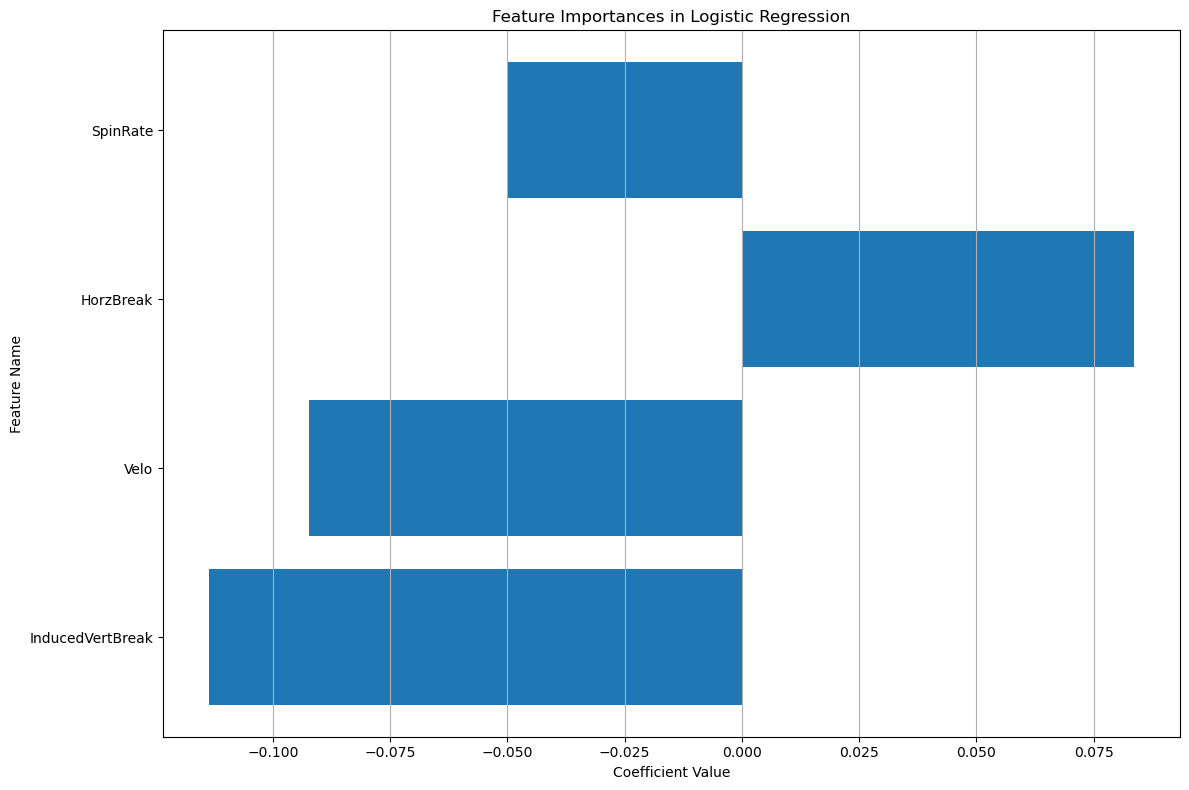

In [46]:
# Get feature names and coefficients
feature_names = X_train_full.columns
coefficients = best_model.coef_[0]

# Sort the features by their importance (absolute value of coefficient)
sorted_indices = [index for index, _ in sorted(enumerate(coefficients), key=lambda x: -abs(x[1]))]

plt.figure(figsize=(12, 8))
plt.barh(range(len(feature_names)), coefficients[sorted_indices])
plt.yticks(range(len(feature_names)), [feature_names[i] for i in sorted_indices])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.title('Feature Importances in Logistic Regression')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

Written Answers:

2) The first step in cleaning the data was to check for any missing values, since this was not severe I decided to delete the rows where the spin rate was missing. I decided to use SMOTE for addressing the class imbalance, since this is the best technique I have used for oversampling. I decided to normalize the data since the scales were quite different between features. Using the standard scaler is a good approach to solving this. I decided to use 5 commonly used models, 3 of them boosting which typically perform well. I used a few different approaches for evaluating these models, for the sake of not just using one method. However, F1 Score is what I would rely on the most from my experience. I also trust testing the models on "unseen" data since this is more of a realistic evaluation. To do this, I just randomly sample 1,000 rows from the training data. I used this approach for determining the final model (Logistic Regression) even though SVM seemed to have been the best model from the previous two approaches. 

3) Above is a plot that shows how the 4 variables affect the batters ability to put the ball in play. The velocity, induced vertical break, and spin rate negatively affect the batters ability to the put the ball in play while the horizontal break has a positive affect. The induced vertical break has the greatest negative affect, so it may be best to focus on pitches that start low and end high, or travel on an upward slant trajectory. 

4) The modeling process above was simple and straigh5t forward due to the time constraint. Throughout the modeling process, I would do a number of steps given some more time such as feature engineering, hyperparameter tuning, using all suitable models for binary classification, using more data if available, as well as using more visuals and exploring/ researching other methods for evaluating the models. I would also consider other methods for addressing the class imbalance other than synthetic sampling. Oversampling is probably most common but I could consider under sampling as well. 